In [5]:
import torch
import torch.nn as nn

from torchvision import models

In [61]:
import numpy as np
import os
import pickle
import torch
import torch.nn.functional as F
import torch.utils.data as data
import matplotlib.pyplot as plt

from torch.autograd import Variable

INPUT_DIM = 224
MAX_PIXEL_VAL = 255
MEAN = 58.09
STDDEV = 49.73

class Dataset(data.Dataset):
    def __init__(self, datadir, task, plane, transform, use_gpu):
        super().__init__()
        self.use_gpu = use_gpu
        self.plane = plane
        self.transform = transform

        label_dict = {}
        self.paths = []

        if datadir[-1] == "/":
            datadir = datadir[:-1]
        self.datadir = datadir

        for i, line in enumerate(open(datadir+'-'+task+'.csv').readlines()):
            line = line.strip().split(',')
            filename = line[0]
            label = line[1]
            label_dict[filename] = int(label)

        for filename in os.listdir(os.path.join(datadir, plane)):
            if filename.endswith(".npy"):
                self.paths.append(filename)

        self.labels = [label_dict[path.split(".")[0]] for path in self.paths]

        neg_weight = np.mean(self.labels)
        self.weights = [neg_weight, 1 - neg_weight]

    def weighted_loss(self, prediction, target):
        weights_npy = np.array([self.weights[int(t[0])] for t in target.data])
        weights_tensor = torch.FloatTensor(weights_npy)
        if self.use_gpu:
            weights_tensor = weights_tensor.cuda()
        loss = F.binary_cross_entropy_with_logits(
            prediction, target, weight=Variable(weights_tensor))
        return loss

    def __getitem__(self, index):
        filename = self.paths[index]
        vol = np.load(os.path.join(self.datadir, self.plane, filename))
        plt.imshow(vol[0])
        pad = int((vol.shape[2] - INPUT_DIM)/2)
        if pad != 0:
            vol = vol[:,pad:-pad,pad:-pad]
            
        vol = (vol-np.min(vol))/(np.max(vol)-np.min(vol))*MAX_PIXEL_VAL
        vol = (vol - MEAN) / STDDEV
            
        if(self.transform != None):
            vol = self.transform(vol)
        
        vol = vol[2:vol.shape[0]-2]
        print(vol.shape)
        vol = np.stack((vol,)*3, axis=1)
        vol_tensor = torch.FloatTensor(vol)

        label_tensor = torch.FloatTensor([self.labels[index]])


        return vol_tensor, label_tensor

    def __len__(self):
        return len(self.paths)


def load_data(task="acl", plane="sagittal", transform=None, use_gpu=False):
    train_dir = "data/train"
    valid_dir = "data/valid"

    train_dataset = Dataset(train_dir, task, plane, transform, use_gpu)
    valid_dataset = Dataset(valid_dir, task, plane, transform, use_gpu)

    train_loader = data.DataLoader(
        train_dataset, batch_size=1, num_workers=8, shuffle=True)
    valid_loader = data.DataLoader(
        valid_dataset, batch_size=1, num_workers=8, shuffle=False)

    return train_loader, valid_loader


In [62]:
train_dir = "data/train"
train_sagittal_dataset = Dataset(datadir=train_dir, task='acl', plane='sagittal', transform=None, use_gpu=True)
train_axial_dataset = Dataset(datadir=train_dir, task='acl', plane='axial', transform=None, use_gpu=True)
train_coronal_dataset = Dataset(datadir=train_dir, task='acl', plane='coronal', transform=None, use_gpu=True)

(31, 224, 224)
torch.Size([31, 3, 224, 224])
(37, 224, 224)
torch.Size([37, 3, 224, 224])
(34, 224, 224)
torch.Size([34, 3, 224, 224])


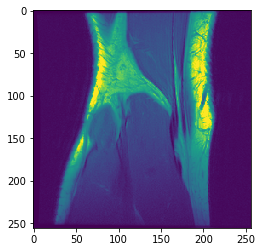

In [63]:
print(train_sagittal_dataset[0][0].shape)
print(train_axial_dataset[0][0].shape)
print(train_coronal_dataset[0][0].shape)

In [64]:
model = models.GoogLeNet()

(31, 224, 224)


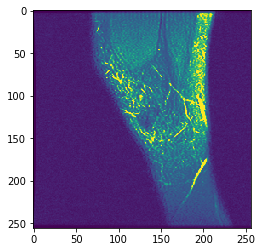

In [69]:
x = model(train_sagittal_dataset[0][0])

In [76]:
x.logits.shape

torch.Size([31, 1000])